<a href="https://colab.research.google.com/github/heraclex12/AutomaticPurchaseShoes/blob/master/Conversation_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install vncorenlp

     |████████████████████████████████| 2.7MB 2.7MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp36-none-any.whl size=2645934 sha256=5db9def5ac1addceaaca5c5734e49f8d5572e94d677d1e09faba8978a77e1661
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp


In [2]:
import os
os.chdir('drive/My Drive/vncorenlp/bert_models')

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from vncorenlp import VnCoreNLP
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import csv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_colwidth', -1)

In [151]:
df_train = pd.read_csv('../conversation_data/training_set_with_tokenize.csv')

df_test = pd.read_csv('../conversation_data/test_set_with_tokenize.csv')

In [69]:
def print_qa(df, idx):
  question = df.iloc[idx].question
  answer = df.iloc[idx].answer
  # print("is_unsatisfied: ", df.iloc[idx].is_unsatisfied)
  print(len(question.split('|||')), len(answer.split('|||')))
  print(question.split('|||'))
  print(answer.split('|||'))
  print(list(zip(question.split('|||'), answer.split('|||'))))



print_pair_qa(df_test, 924)

2 4
['mình cần trợ giúp ạ', 'xin chào']
['dạ cho em hỏi mình có đang theo dõi chat cùng em không ạ', 'cảm ơn anh chị đã liên hệ với call center em là như hảo em rất sẵn lòng hỗ trợ anh chị ạ anh chị cho em xin biết tên của mình để em tiện xưng hô ạ', 'nếu anh chị đang có việc chưa tiện trao đổi thì anh chị có thể chat với em dịp khác ạ hiện tại em xin phép kết thúc cuộc trò chuyện và phản hồi qua email ạ', 'nếu cần thêm thông tin mình cứ chat tại đây hoặc cập nhật thông tin cần hỗ trợ vào biểu mẫu sau code để bên em có thể nhận được thông tin của anh chị kịp thời ạ']
[('mình cần trợ giúp ạ', 'dạ cho em hỏi mình có đang theo dõi chat cùng em không ạ'), ('xin chào', 'cảm ơn anh chị đã liên hệ với call center em là như hảo em rất sẵn lòng hỗ trợ anh chị ạ anh chị cho em xin biết tên của mình để em tiện xưng hô ạ')]


In [92]:
# def clean_noise(s):
#   noise_words = [
#                  'hi',
#                  'hello',
#                  'xin chào',
#                  'chào bạn',
#                  'alo'
#   ]
#   if s.count('|||') > 0:
#     for n_w in noise_words:
#       s = s.replace(n_w, '')
#     return s
#   else:
#     return None


# df_train = df_train[df_train.question.apply(clean_noise).notnull()]
# train_labels = df_train.is_unsatisfied.apply(lambda y: 1 if y == 'Y' else 0).values
# df_train['qa_joined'] = df_train[['question', 'answer']].apply(lambda row: row[0] + "|||" + row[1], axis=1)
# df_test['qa_joined'] = df_test[['question', 'answer']].apply(lambda row: row[0] + "|||" + row[1], axis=1)
# data_train = df_train.qa_joined.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values
# data_test = df_test.qa_joined.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values

# def transform_text(X):
#     conversations = [". ".join(messages.lower().split('|||')) for messages in X]
#     conversations = [" ".join(" ".join(sentence) for sentence in tokenizer.tokenize(message)) for message in conversations]
#     return conversations

# tokenizer = VnCoreNLP('VnCoreNLP-1.1.1.jar', annotators='wseg')
# data_train = transform_text(data_train)
# data_test = transform_text(data_test)

In [152]:
import re
import string


train_labels = df_train.is_unsatisfied.apply(lambda y: 1 if y == 'Y' else 0).values
data_train_q = df_train.question.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values
data_test_q = df_test.question.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values
data_train_a = df_train.answer.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values
data_test_a = df_test.answer.apply(lambda s: re.sub('[' + string.punctuation + ']', ' ', s)).values

def transform_text(X):
    conversations = [". ".join(messages.lower().split('|||')) for messages in X]
    conversations = [" ".join(" ".join(sentence) for sentence in tokenizer.tokenize(message)) for message in conversations]
    return conversations

tokenizer = VnCoreNLP('VnCoreNLP-1.1.1.jar', annotators='wseg')
data_train_q = transform_text(data_train_q)
data_test_q = transform_text(data_test_q)
data_train_a = transform_text(data_train_a)
data_test_a = transform_text(data_test_a)

In [153]:
def oversampling_data(features, labels):
  '''
    Our implementation of oversampling method.
  '''
  while sum(labels == 0) / sum(labels == 1) > 5.:
    features = np.concatenate([features[labels == 1], features])
    labels = np.concatenate([labels[labels == 1], labels])

  return features, labels


# over_features, over_labels = oversampling_data(data_train, train_labels)

#### TF-IDF Transform

In [159]:
vectorize_q = TfidfVectorizer(use_idf=True)

train_vector_q = vectorize_q.fit_transform(data_train_q)
test_vector_q = vectorize_q.transform(data_test_q)


vectorize_a = TfidfVectorizer(use_idf=True)

train_vector_a = vectorize_a.fit_transform(data_train_a)
test_vector_a = vectorize_a.transform(data_test_a)

In [160]:
import scipy.sparse

train_vector = scipy.sparse.hstack([train_vector_q, train_vector_a])
test_vector = scipy.sparse.hstack([test_vector_q, test_vector_a])

#### SMOTE Oversampling

In [161]:
smote = SMOTE(random_state=42)

over_features, over_labels = smote.fit_resample(train_vector, train_labels)

## RandomForest Model

In [162]:
rf = RandomForestClassifier(random_state=42)
rf.fit(over_features, over_labels)

preds = rf.predict(over_features)
print('\nAccuracy: {}\nF1-score: {}\n'.format(accuracy_score(preds, over_labels), f1_score(preds, over_labels, labels=[0, 1], pos_label=1)))


Accuracy: 0.9998338410412628
F1-score: 0.9998338318378198



## LogisticRegression Model

In [22]:
clf = LogisticRegression(C=10, random_state=42)

clf.fit(over_features, over_labels)

preds = clf.predict(over_features)
print('\nAccuracy: {}\nF1-score: {}\n'.format(accuracy_score(preds, over_labels), f1_score(preds, over_labels, labels=[0, 1], pos_label=1)))


Accuracy: 0.9772362226530047
F1-score: 0.9777042421612238



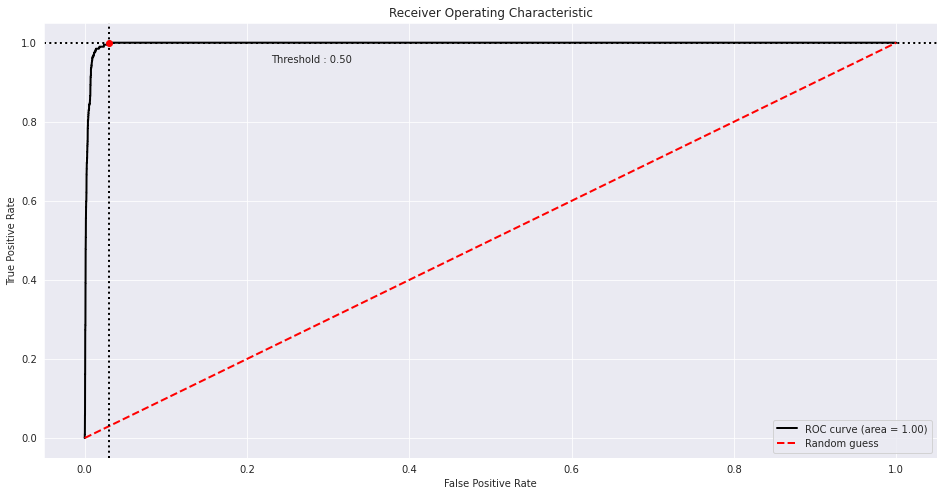

In [ ]:
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt

bc = BinaryClassification(train_labels, clf.predict_proba(train_vector)[:, 1], labels=[0, 1])
plt.figure(figsize=(16,8))
bc.plot_roc_curve()
plt.show()

## Support Vector Machine Model

In [30]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_idx, val_idx in sss.split(data_train, train_labels):
  clf_pipeline = Pipeline([
                        ('vectorize', TfidfVectorizer(use_idf=True)),
                        ('clf', SVC(kernel='rbf', C = 10))
  ])
  clf_pipeline.fit(data_train[train_idx], train_labels[train_idx])

  print("Y label for Training={}\nY label for Validation={}".format(sum(train_labels[train_idx] == 1), sum(train_labels[val_idx] == 1)))
  preds = clf_pipeline.predict(data_train[train_idx])
  print("=====Training set:")
  print('\nAccuracy: {}\nF1-score: {}\n'.format(accuracy_score(preds, train_labels[train_idx]), f1_score(preds, train_labels[train_idx], labels=[0, 1], pos_label=1)))
  
  preds = clf_pipeline.predict(data_train[val_idx])
  print("=====Validation set:")
  print('\nAccuracy: {}\nF1-score: {}\n'.format(accuracy_score(preds, train_labels[val_idx]), f1_score(preds, train_labels[val_idx], labels=[0, 1], pos_label=1)))

Y label for Training=354
Y label for Validation=39
=====Training set:

Accuracy: 0.9984340179485636
F1-score: 0.9618768328445748

=====Validation set:

Accuracy: 0.9799457994579945
F1-score: 0.13953488372093026



## RandomForest Prediction

In [163]:
preds = rf.predict_proba(test_vector)[:, 1]

np.where(preds >= 0.8)


(array([2202]),)

#### Write submission

In [164]:
with open('../conversation_data/submission.csv', 'w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerow(['num', 'label'])
  pred_label = 1*(preds>=0.8)
  for i, label in enumerate(pred_label):
    writer.writerow([i + 1, 'Y' if label == 1 else 'N'])

#### Save model

In [171]:
import pickle

pickle.dump(rf, open('../conversation_data/model.pkl', 'wb'))
pickle.dump(vectorize_q, open('../conversation_data/vectorize_q.pkl', 'wb'))
pickle.dump(vectorize_a, open('../conversation_data/vectorize_a.pkl', 'wb'))